# *Random Forest - Classification for Higgs Signal vs. Background* 

ELEFTHERIOS MARIOS ZOGRAFOS\
AEM : 4428

### *1. Importing Libraries*

> ***Note***: This algorithm utilizes parallel processing routines that depend on the `joblib` module. Please ensure that this module is installed on your system. If not, execute the code block below first. You may need to restart the kernel after installation.

In [1]:
# %pip install joblib

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import parallel_backend
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,roc_curve, roc_auc_score, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

### _2. The Random Forest function_

1. **Splitting the Data into Training and Test Sets**
   - Use the `train_test_split` function from `scikit-learn` to divide the dataset into _**training**_ and _**test**_ sets.
   - Adjust the `test_size` parameter to control the proportion of data allocated for testing.
   - Optionally, set `random_state` for reproducibility.
> ***Note***: No feature scaling is required for tree-based models.

In [3]:
def split_data(X: np.ndarray, y: np.ndarray,
               test_size: float = 0.25,
               random_state: int = 32) -> tuple:
    """
    Stratified split of features X and labels y into training and test sets
    """
    return train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )

2. **Creating the Classifier**

- Define a `param_grid` variable with possible values for the _n_estimators,criterion, max_depth, min_samples_split,_ and _min_samples_leaf_:
    1. **n_estimators**: the number of decision trees in the forest
    2. **criterion**: The function to measure the quality of a split.
    3. **max_depth**: The maximum depth of the tree.
    4. **min_samples_split**:  The minimum number of samples required to split an internal node.
    5. **min_samples_leaf**: The minimum number of samples required to be at a leaf node.

    > ***Note*** : The last three parameters can help prevent overfitting since they limit the depth of the tree.

    More information on these parameters can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

- Implement cross-validation with parallel processing to find the optimal parameters based on the dataset's AUC score.

    > **Notes**:
    > - `n_jobs` is set to `-1` by default to use all available processors. Adjust this value if there are concurrent background processes.
    > - The cross-validation employs a 5-fold approach. Adjust these parameters based on system capabilities and dataset characteristics.


In [4]:
def build_rf_classifier(X_train: np.ndarray,
                        y_train: np.ndarray,
                        n_jobs: int = -1,
                        random_state: int = 32) :
    """
    Build and tune a RandomForestClassifier via GridSearchCV (5-fold CV, optimizing ROC AUC)
    """
    param_grid = {
        'n_estimators': [50, 100, 200],
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    rf = RandomForestClassifier(random_state=random_state)
    with parallel_backend('loky', n_jobs=n_jobs):
        grid = GridSearchCV(
            rf,
            param_grid,
            cv=5,
            scoring='roc_auc',
            n_jobs=n_jobs
        )
        grid.fit(X_train, y_train)
    return grid

3. **Drawing the Confusion Matrix**

  Use the classifier's best parameters, determined earlier, to make predictions on the test set and display the confusion matrix.


In [5]:
def plot_confusion_matrix(clf: GridSearchCV,
                          X_test: np.ndarray,
                          y_test: np.ndarray,
                          title: str):
    """
    Plot a confusion matrix for the classifier's best estimator.
    """
    y_pred = clf.best_estimator_.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(6,5))
    disp = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)
    disp.plot(ax=ax, values_format='d')
    ax.set_title(f'Confusion Matrix - {title}')
    fig.tight_layout()
    plt.show()

4. **Drawing the Model's _ROC_ Curve & Calculating the Model's _Parameters_ and _Accuracy_**

In [6]:
def plot_roc_and_stats(clf: GridSearchCV,
                       X_test: np.ndarray,
                       y_test: np.ndarray,
                       title: str) -> dict:
    """
    Plot ROC curve and return performance metrics: AUC and accuracy at 0.5 threshold.
    """
    y_prob = clf.best_estimator_.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    fig, ax = plt.subplots(figsize=(6,5))
    ax.plot([0, 1], [0, 1], '--', color='gray')
    ax.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_prob):.3f}')
    ax.set_title(f'ROC Curve - {title}')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend()
    fig.tight_layout()
    plt.show()
    return {
        'AUC': roc_auc_score(y_test, y_prob),
        'Accuracy': accuracy_score(y_test, (y_prob > 0.5).astype(int))
    }

### ***Results***

1. **Loading the Data**

   - First, load the data into a DataFrame.
   
     > **_Note:_** The dataset contains instances of `e+00.1`, which Python does not recognize as numeric values by default. To prevent errors, these values must be modified as shown below.


In [7]:
df = pd.read_csv('HIGGS_8K.csv',header= None).replace(to_replace=r'[eE]\+?\d+\.\d+', value=0, regex=True).astype(np.float64)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,...,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,0.0,1.630428,0.404143,0.401026,2.722409,0.355644,1.362199,0.015818,-1.174111,0.000000,...,0.387635,1.596321,1.550981,0.859235,0.827233,0.995416,0.764766,0.520597,0.850413,0.929865
2,1.0,0.326305,-0.797735,0.223471,1.248234,-1.427857,0.923767,-0.278280,-0.470052,0.000000,...,-0.426866,1.153501,0.000000,0.887944,0.924601,0.987189,0.854094,0.385013,0.789912,0.724627
3,1.0,1.381170,0.521993,0.574698,0.357347,0.037136,0.413057,-0.607036,-1.308270,0.000000,...,0.567525,-1.475778,0.000000,0.936186,1.107217,0.983808,0.693327,0.562045,0.825387,0.846233
4,1.0,0.304161,-0.736375,0.686225,0.477172,-1.274736,0.907003,0.324770,-0.463954,2.173076,...,0.904818,1.165154,0.000000,1.181790,1.033701,0.993943,0.648399,0.936097,0.732592,0.661779


2. **Execute Random Forest Analysis**  

     > _e.g._ , on an _Intel(R) Core(TM) i7-8750H @ 2.2GHz_, it takes approximately _32 minutes_.

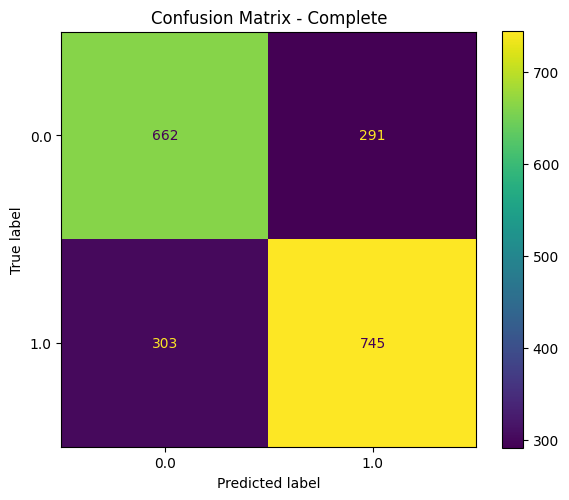

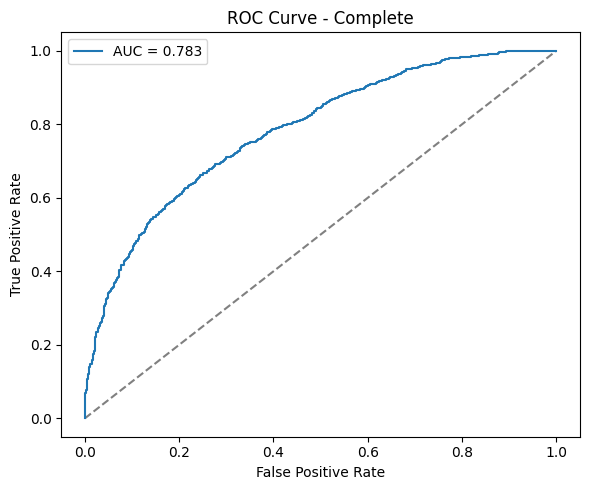

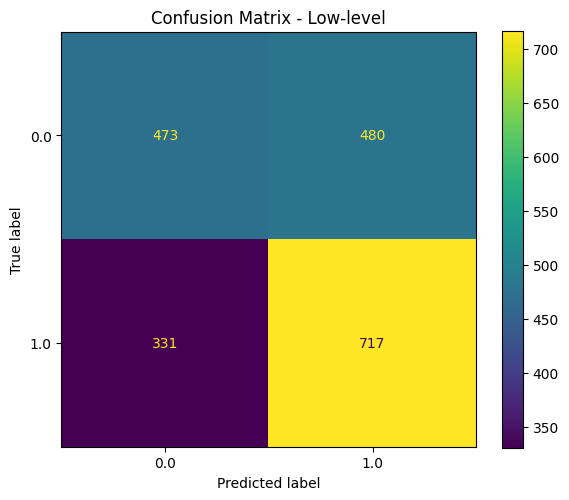

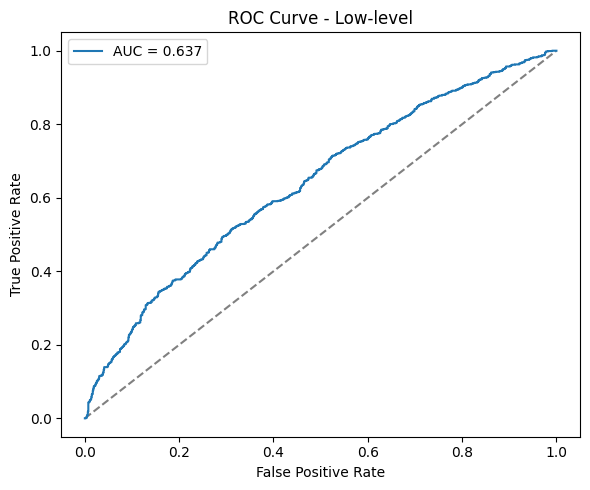

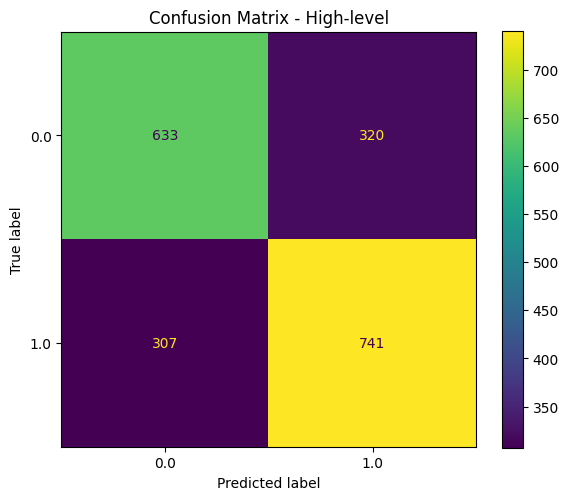

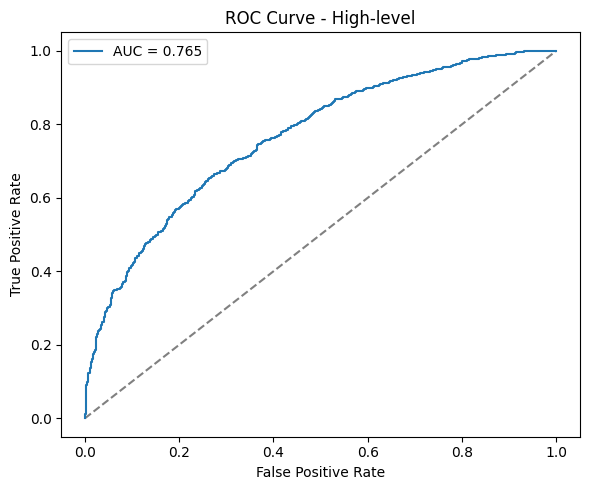

In [8]:
y = df.iloc[:, 0]
feature_sets = {
    'Complete': df.iloc[:, 1:],
    'Low-level': df.iloc[:, 1:22],
    'High-level': df.iloc[:, 22:]
}

results = {}
for label, X in feature_sets.items():
    # Split data
    X_train, X_test, y_train, y_test = split_data(X, y)
    # Build and tune classifier
    clf = build_rf_classifier(X_train, y_train)
    # Plot confusion matrix
    plot_confusion_matrix(clf, X_test, y_test, label)
    # Plot ROC and capture metrics
    stats = plot_roc_and_stats(clf, X_test, y_test, label)
    # Append best hyperparameters
    stats.update({
        'n_estimators': clf.best_params_['n_estimators'],
        'criterion': clf.best_params_['criterion'],
        'max_depth': clf.best_params_['max_depth'],
        'min_samples_split': clf.best_params_['min_samples_split'],
        'min_samples_leaf': clf.best_params_['min_samples_leaf']
    })
    results[label] = stats


### ***Summary***

In [9]:
# Summarize Results
results_df = pd.DataFrame(results).T
results_df

,AUC,Accuracy,n_estimators,criterion,max_depth,min_samples_split,min_samples_leaf
Complete,0.783254,0.703148,200,entropy,30,10,4
Low-level,0.637355,0.594703,200,gini,None,5,2
High-level,0.765077,0.686657,200,gini,20,10,4
